In [2]:
!pip uninstall tensorflow -y
!pip install tensorflow
!pip install tensorflow-addons==0.22.0

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
  Using cached tensorflow-2.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.19.0 which is incompatible.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
import os
import math
#import tensorflow_addons as tfa

In [4]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
BASE_DIR = Path('/kaggle/input/captcha-dataset')


IMAGES = sorted(list(map(str, list(BASE_DIR.glob('*.jpg')))))
LABELS = [img.split(os.path.sep)[-1].split('.jpg')[0] for img in IMAGES]
CHARACTERS = set(char for LABEL in LABELS for char in LABEL)

print(f'Number of Images found: {len(IMAGES)}')
print(f'Number of Labels found: {len(LABELS)}')
print(f'Number of Unique Characters found: {len(CHARACTERS)}')
print(f'Character List: {CHARACTERS}')

Number of Images found: 113062
Number of Labels found: 113062
Number of Unique Characters found: 60
Character List: {'3', 'S', 'E', 'B', 'G', 'P', 'V', 'j', 'T', 'C', '9', 'F', 'm', 'a', '2', 'A', 'U', 'r', 'h', 'v', 'Z', 'z', 'w', 's', '1', 'R', '4', 'Y', 'l', '6', 'k', 'O', 'I', 'u', 'N', 't', 'K', 'Q', 'M', 'W', 'X', 'D', 'd', 'b', '8', 'p', 'g', '5', 'y', 'f', 'L', 'q', 'J', 'n', 'i', 'x', 'c', 'H', 'e', '7'}


In [6]:
IMAGES[0], LABELS[0]

('/kaggle/input/captcha-dataset/111J8.jpg', '111J8')

In [7]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

IMG_WIDTH, IMG_HEIGHT = 150, 40
downsample_factor = 4
max_length = max([len(label) for label in LABELS])
MAX_CHARS = len(CHARACTERS)
max_length

5

# Data Pre-Processing

In [9]:
CHARACTERS = list(CHARACTERS)
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS),
                                  num_oov_indices=0,
                                  mask_token=None)

vocab = char_to_num.get_vocabulary()


num_to_char = layers.StringLookup(vocabulary=vocab,  
                                  mask_token=None, 
                                  num_oov_indices=0,
                                  invert=True)


print(CHARACTERS)
print("***"*5)
print(vocab)

['3', 'S', 'E', 'B', 'G', 'P', 'V', 'j', 'T', 'C', '9', 'F', 'm', 'a', '2', 'A', 'U', 'r', 'h', 'v', 'Z', 'z', 'w', 's', '1', 'R', '4', 'Y', 'l', '6', 'k', 'O', 'I', 'u', 'N', 't', 'K', 'Q', 'M', 'W', 'X', 'D', 'd', 'b', '8', 'p', 'g', '5', 'y', 'f', 'L', 'q', 'J', 'n', 'i', 'x', 'c', 'H', 'e', '7']
***************
['3', 'S', 'E', 'B', 'G', 'P', 'V', 'j', 'T', 'C', '9', 'F', 'm', 'a', '2', 'A', 'U', 'r', 'h', 'v', 'Z', 'z', 'w', 's', '1', 'R', '4', 'Y', 'l', '6', 'k', 'O', 'I', 'u', 'N', 't', 'K', 'Q', 'M', 'W', 'X', 'D', 'd', 'b', '8', 'p', 'g', '5', 'y', 'f', 'L', 'q', 'J', 'n', 'i', 'x', 'c', 'H', 'e', '7']


In [10]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_samples = int(size * train_size)
    
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

In [11]:
def encode_single_sample(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.one_hot(indices=label, depth=MAX_CHARS+1)
    # return {'image': img, 'label':label}
    return img, label

In [12]:
X_train, X_valid, y_train, y_valid = split_data(np.array(IMAGES), np.array(LABELS))

In [13]:
X_train[0], y_train[0], tf.strings.reduce_join(num_to_char(char_to_num(tf.strings.unicode_split(y_train[0], input_encoding="UTF-8")))).numpy().decode('utf-8')

('/kaggle/input/captcha-dataset/Lqf4L.jpg', 'Lqf4L', 'Lqf4L')

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

valid_dataset = (
    valid_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


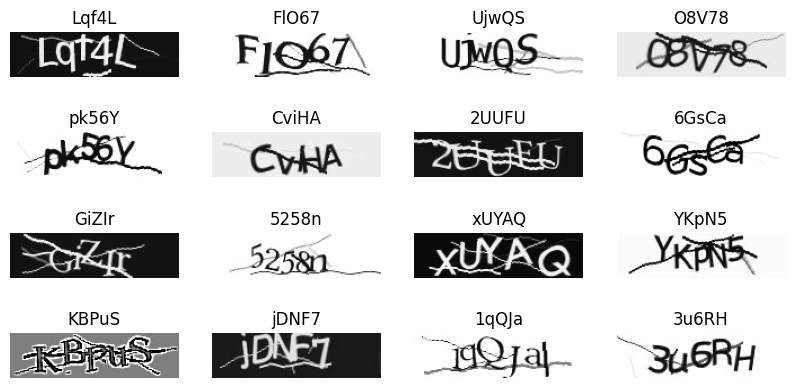

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
        
#    images = batch['image']
#    labels = batch['label']
    images = batch[0]
    labels = batch[1]
    # print(batch[1].shape)
    # print('Single Label Shape', labels[0].shape,' Label Value is: ', labels[0])
    for i in range(16):
        img = (images[i]*255).numpy().astype('uint8')
        ori_label = []
        
        for l in labels[i]:
            ori_label.append(np.argmax(l))
        
        label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

## Model

In [17]:
class SqueezeLayer(layers.Layer):
    def __init__(self, name='squeeze_layer'):
        super().__init__(name=name)
        pass
        
    def call(self, inp):
        return tf.squeeze(inp, axis=2)

In [18]:
class SqueezeLayer(layers.Layer):
    def __init__(self, name='squeeze_layer'):
        super().__init__(name=name)
        pass
        
    def call(self, inp):
        return tf.squeeze(inp, axis=2)


def get_model_2():
    
    tf.random.set_seed(108)
    
    img_inp = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name='image')
    
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv_1')(img_inp)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name="conv_3_bn")(x)
    x = layers.ReLU(name="conv_3_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name="conv_4_bn")(x)
    x = layers.ReLU(name="conv_4_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_4')(x)
    
    x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name="conv_5_bn")(x)
    x = layers.ReLU(name="conv_5_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_5')(x)

    x = layers.GlobalAveragePooling2D()(x)
  
    x = layers.Dense(max_length * (len(CHARACTERS) + 4), name='dense_3')(x)
    x = layers.BatchNormalization(name="dense_3_bn")(x)
    x = layers.ReLU(name="dense_3_relu")(x)
    x = layers.Dropout(0.5)(x)

    new_shape = (max_length , len(CHARACTERS) + 4)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    
    x = layers.Dense(64, name='dense_4')(x)    
    x = layers.BatchNormalization(name="dense_4_bn")(x)
    x = layers.ReLU(name="dense_4_relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(len(CHARACTERS) + 1, name='dense_prediction')(x)
    x = layers.BatchNormalization(name="prediction_bn")(x)
    out = layers.Activation('softmax', name='prediction')(x)
    
    model = tf.keras.Model(img_inp, out, name="OCR_Model")

    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc', tf.keras.metrics.AUC(name='auc'), ])
    model.summary()
    
    return model

In [19]:
model_2 = get_model_2()

Model: "OCR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 150, 40, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 150, 40, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, 150, 40, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, 150, 40, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 75, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 75, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, 75, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, 75, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 37, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 37, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3_bn (BatchNormalization)       │ (None, 37, 10, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3_relu (ReLU)                   │ (None, 37, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 18, 5, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 18, 5, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4_bn (BatchNormalization)       │ (None, 18, 5, 256)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4_relu (ReLU)                   │ (None, 18, 5, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_4 (MaxPooling2D)                │ (None, 9, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5 (Conv2D)                      │ (None, 9, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5_bn (BatchNormalization)       │ (None, 9, 2, 512)           │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5_relu (ReLU)                   │ (None, 9, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_5 (MaxPooling2D)                │ (None, 4, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,746,033 (6.66 MB)

 Trainable params: 1,743,159 (6.65 MB)

 Non-trainable params: 2,874 (11.23 KB)

In [20]:
EPOCHS = 100
PATIENCE = 10
initial_learning_rate = 0.01

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))


lrate = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=0)

history = model_2.fit(
    train_dataset, 
    validation_data=valid_dataset, 
    epochs=EPOCHS, 
    callbacks=[lrate, early_stopping]
)

Epoch 1/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 220s 74ms/step - acc: 0.0165 - auc: 0.5074 - loss: 4.1333 - val_acc: 0.0164 - val_auc: 0.5070 - val_loss: 4.0987 - learning_rate: 0.0100
Epoch 2/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - acc: 0.0587 - auc: 0.7039 - loss: 3.7183 - val_acc: 0.1976 - val_auc: 0.8937 - val_loss: 2.7762 - learning_rate: 0.0100
Epoch 3/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - acc: 0.2464 - auc: 0.9328 - loss: 2.3914 - val_acc: 0.3145 - val_auc: 0.9387 - val_loss: 2.2013 - learning_rate: 0.0100
Epoch 4/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - acc: 0.3716 - auc: 0.9575 - loss: 1.9176 - val_acc: 0.3855 - val_auc: 0.9584 - val_loss: 1.8922 - learning_rate: 0.0100
Epoch 5/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - acc: 0.4450 - auc: 0.9666 - loss: 1.6647 - val_acc: 0.5358 - val_auc: 0.9783 - val_loss: 1.3905 - learning_rate: 0.0100
Epoch 6/100
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - acc: 0.4917 - auc: 0.9717 - loss: 1.5085 - va

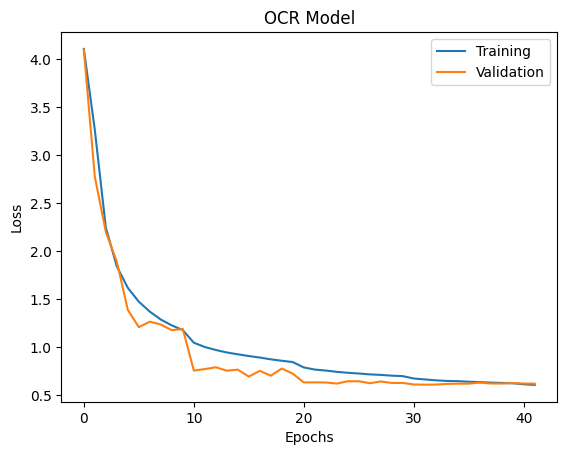

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('OCR Model')
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

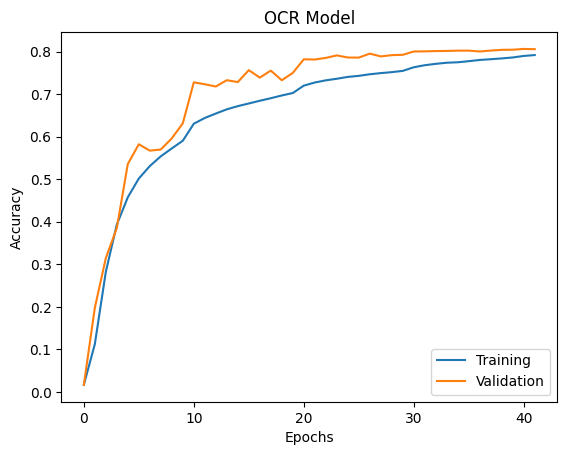

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('OCR Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [28]:
val_loss, val_acc, val_auc = model_2.evaluate(valid_dataset, verbose=0)
print(f'Validation Accuracy: {val_acc*100:.3f}%')

Validation Accuracy: 80.069%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


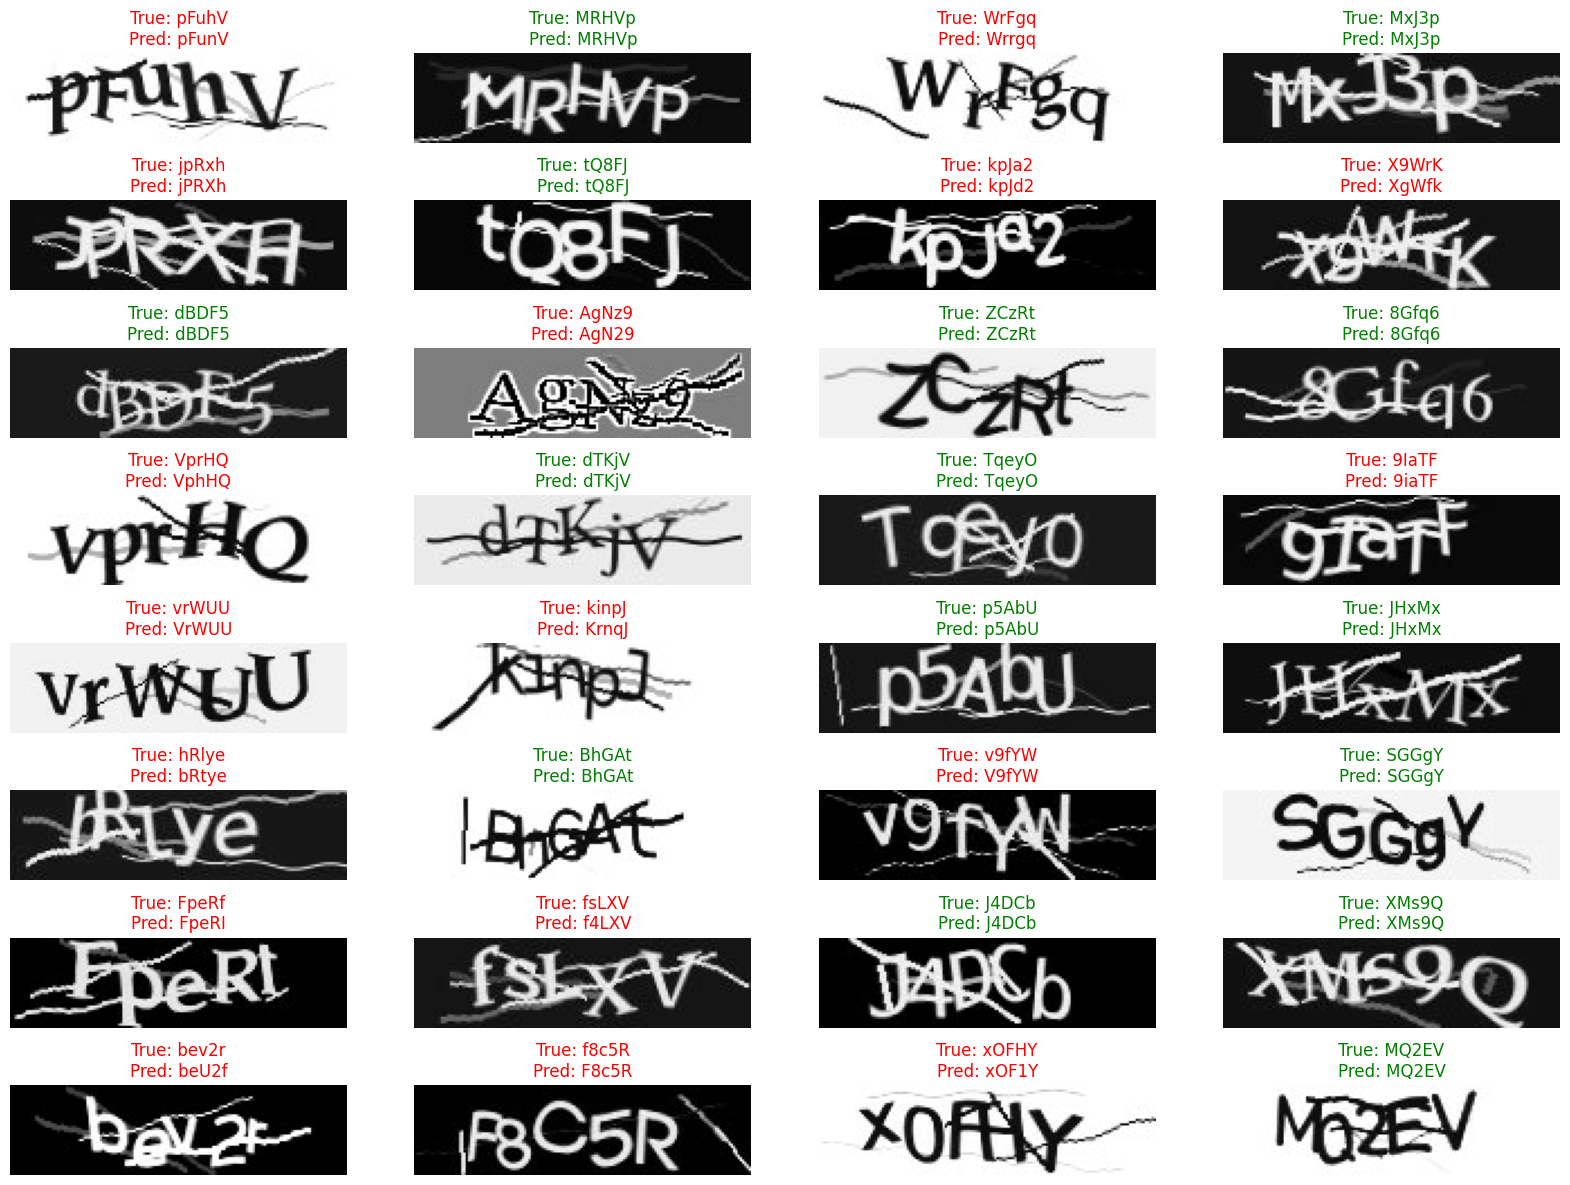

In [29]:
_, ax = plt.subplots(8, 4, figsize=(20, 15))
for batch in valid_dataset.take(1):
    images = batch[0]
    labels = batch[1]

    preds = model_2.predict(images)

    for i in range(8):
        for j in range(4):
            index = i*4+j
            
            img = (images[index]*255).numpy().astype('uint8')

            ori_label = []
            pre_label = []

            for l in labels[index]:
                ori_label.append(np.argmax(l))

            for l in preds[index]:
                pre_label.append(np.argmax(l))

            
            true_label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
            pred_label = tf.strings.reduce_join(num_to_char(pre_label)).numpy().decode('utf-8')

            if true_label == pred_label:
                title_color = 'green'
            else:
                title_color = 'red'
                
            ax[i, j].imshow(img[:, :, 0].T, cmap='gray')
            ax[i, j].set_title('True: '+true_label+'\nPred: '+pred_label, color=title_color)
            ax[i, j].axis('off')
plt.show()

In [30]:
model_2.save('ocr_model.h5')